# **A. Importación de datos**

En esta sección, se importan las bibliotecas necesarias y se cargan los datos desde
la fuente correspondiente, ya sea un archivo CSV, una base de datos, u otro
formato. Es el primer paso para comenzar a trabajar con los datos.

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import xgboost as xgb

In [23]:

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('submission.csv')

print("Train DataFrame:")
print(train_df.head())

print("\nTest DataFrame:")
print(test_df.head())

print("\nSubmission DataFrame:")
print(submission_df.head())

Train DataFrame:
       ID  PERIODO         ESTU_PRGM_ACADEMICO ESTU_PRGM_DEPARTAMENTO  \
0  904256    20212                  ENFERMERIA                 BOGOTÁ   
1  645256    20212                     DERECHO              ATLANTICO   
2  308367    20203       MERCADEO Y PUBLICIDAD                 BOGOTÁ   
3  470353    20195  ADMINISTRACION DE EMPRESAS              SANTANDER   
4  989032    20212                  PSICOLOGIA              ANTIOQUIA   

             ESTU_VALORMATRICULAUNIVERSIDAD ESTU_HORASSEMANATRABAJA  \
0  Entre 5.5 millones y menos de 7 millones       Menos de 10 horas   
1  Entre 2.5 millones y menos de 4 millones                       0   
2  Entre 2.5 millones y menos de 4 millones         Más de 30 horas   
3  Entre 4 millones y menos de 5.5 millones                       0   
4  Entre 2.5 millones y menos de 4 millones     Entre 21 y 30 horas   

  FAMI_ESTRATOVIVIENDA FAMI_TIENEINTERNET                 FAMI_EDUCACIONPADRE  \
0            Estrato 3              

# **B. Limpieza de datos**

Aquí se lleva a cabo el proceso de limpieza de datos para abordar posibles
problemas, como valores faltantes, duplicados, errores de formato, etc. También
puede incluir la codificación de variables categóricas, normalización de datos, y
cualquier otro paso necesario para preparar los datos para el modelado.

In [24]:
train_ids = train_df['ID']
test_ids = test_df['ID']


train_df = train_df.drop('ID', axis=1)
test_df = test_df.drop('ID', axis=1)


print("Valores faltantes en el conjunto de entrenamiento:")
print(train_df.isnull().sum())

print("\nValores faltantes en el conjunto de prueba:")
print(test_df.isnull().sum())

for column in train_df.columns:
    if train_df[column].dtype == 'object' and column != 'RENDIMIENTO_GLOBAL':
        train_df[column] = train_df[column].fillna(train_df[column].mode()[0])
    elif column != 'RENDIMIENTO_GLOBAL':
        train_df[column] = train_df[column].fillna(train_df[column].median())

for column in test_df.columns:
    if test_df[column].dtype == 'object':
        test_df[column] = test_df[column].fillna(test_df[column].mode()[0])
    else:
        test_df[column] = test_df[column].fillna(test_df[column].median())

label_encoders = {}
for column in train_df.columns:
    if train_df[column].dtype == 'object' and column != 'RENDIMIENTO_GLOBAL':
        le = LabelEncoder()
        combined_data = pd.concat([train_df[column], test_df[column]], axis=0)
        le.fit(combined_data)
        train_df[column] = le.transform(train_df[column])
        test_df[column] = le.transform(test_df[column])
        label_encoders[column] = le

rendimiento_mapping = {
    'bajo': 0,
    'medio-bajo': 1,
    'medio-alto': 2,
    'alto': 3
}
train_df['RENDIMIENTO_GLOBAL'] = train_df['RENDIMIENTO_GLOBAL'].map(rendimiento_mapping)

print("Train DataFrame después de la limpieza y conversión:")
print(train_df.head())

print("\nTest DataFrame después de la limpieza y conversión:")
print(test_df.head())


Valores faltantes en el conjunto de entrenamiento:
PERIODO                               0
ESTU_PRGM_ACADEMICO                   0
ESTU_PRGM_DEPARTAMENTO                0
ESTU_VALORMATRICULAUNIVERSIDAD     6287
ESTU_HORASSEMANATRABAJA           30857
FAMI_ESTRATOVIVIENDA              32137
FAMI_TIENEINTERNET                26629
FAMI_EDUCACIONPADRE               23178
FAMI_TIENELAVADORA                39773
FAMI_TIENEAUTOMOVIL               43623
ESTU_PRIVADO_LIBERTAD                 0
ESTU_PAGOMATRICULAPROPIO           6498
FAMI_TIENECOMPUTADOR              38103
FAMI_TIENEINTERNET.1              26629
FAMI_EDUCACIONMADRE               23664
RENDIMIENTO_GLOBAL                    0
dtype: int64

Valores faltantes en el conjunto de prueba:
PERIODO                               0
ESTU_PRGM_ACADEMICO                   0
ESTU_PRGM_DEPARTAMENTO                0
ESTU_VALORMATRICULAUNIVERSIDAD     2723
ESTU_HORASSEMANATRABAJA           13379
FAMI_ESTRATOVIVIENDA              13795
FAMI_TIENEI

En esta parte se realizo la eliminacion de la variable ID ya que no es una variable que influya en las demas dada su naturaleza, ademas se rellenaron los valores faltantes con la media dada por los valores que si existen de esa categoria, tambien se cambiaron todas las variables categoricas a numericas para su posterior analisis 

# **C. Exploración de datos**

En esta sección, se realizan análisis exploratorios de los datos para comprender
mejor su estructura y distribución. Puede incluir visualizaciones, estadísticas
descriptivas y la identificación de patrones interesantes en los datos.

**Descripción General del Conjunto de Datos**

In [4]:

print("Descripción general del conjunto de datos de entrenamiento:")
print(train_df.describe(include='all'))


print("\nDescripción general del conjunto de datos de prueba:")
print(test_df.describe(include='all'))

Descripción general del conjunto de datos de entrenamiento:
             PERIODO  ESTU_PRGM_ACADEMICO  ESTU_PRGM_DEPARTAMENTO  \
count  692500.000000        692500.000000           692500.000000   
mean    20198.366679           423.346495                9.652276   
std        10.535037           299.298073                9.299005   
min     20183.000000             0.000000                0.000000   
25%     20195.000000           206.000000                4.000000   
50%     20195.000000           381.000000                4.000000   
75%     20203.000000           712.000000               17.000000   
max     20213.000000           957.000000               30.000000   

       ESTU_VALORMATRICULAUNIVERSIDAD  ESTU_HORASSEMANATRABAJA  \
count                   692500.000000            692500.000000   
mean                         2.372972                 2.431266   
std                          2.256012                 1.548861   
min                          0.000000                 

**Distribución de la Variable Objetivo (RENDIMIENTO_GLOBAL)**

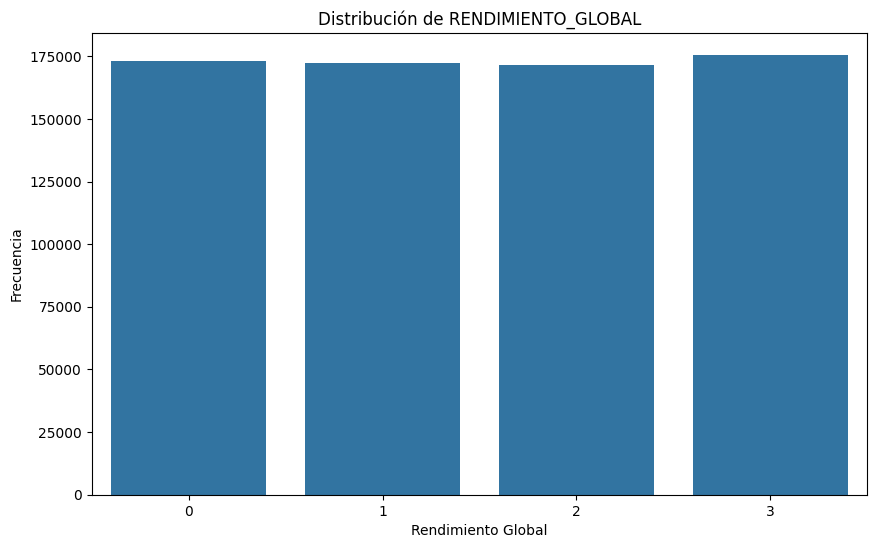

In [5]:



plt.figure(figsize=(10, 6))
sns.countplot(x='RENDIMIENTO_GLOBAL', data=train_df)
plt.title('Distribución de RENDIMIENTO_GLOBAL')
plt.xlabel('Rendimiento Global')
plt.ylabel('Frecuencia')
plt.show()

En esta grafica se ve que no hay un valor predominante en el rendimeiento global ya que hay valores muy similares de estudiantes que tienen cada tipo de desempeño 

**Correlación entre Variables**

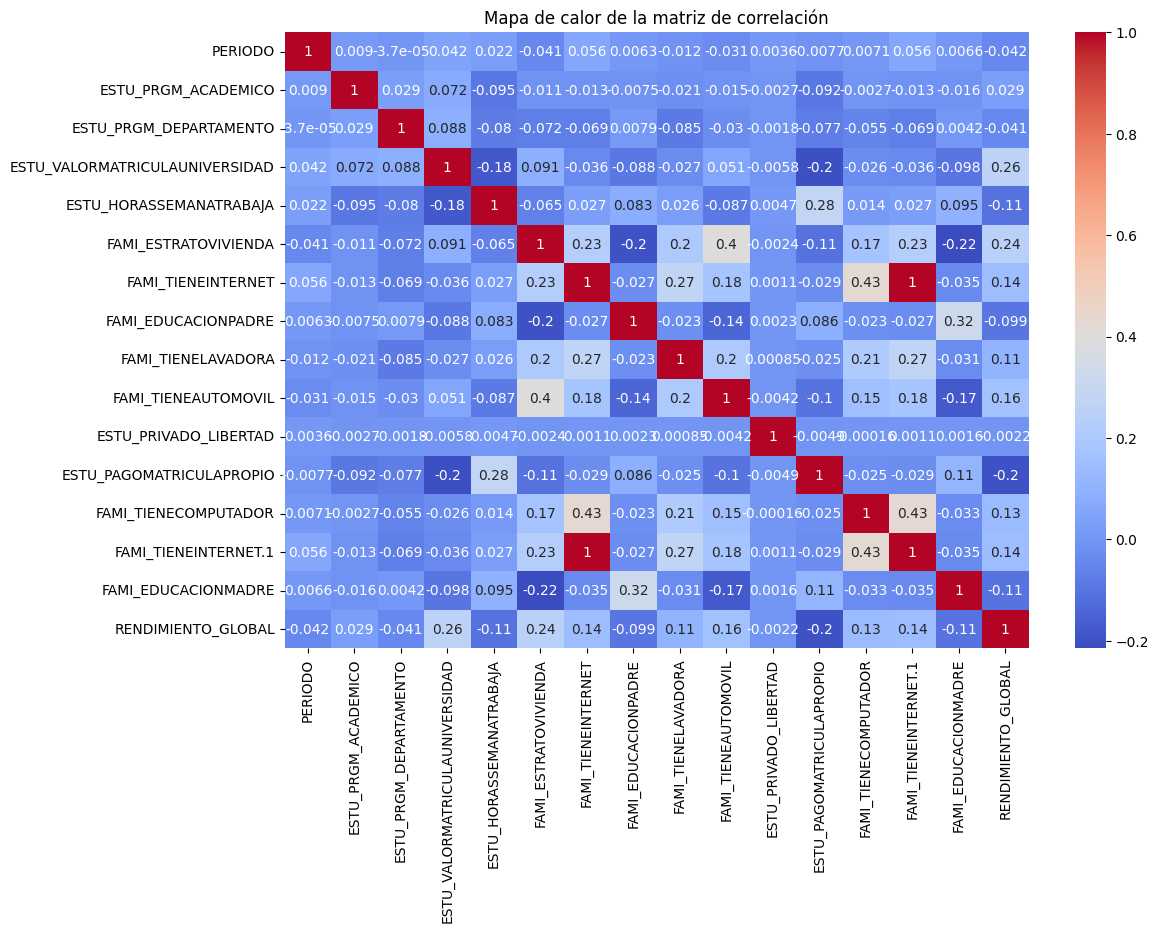

In [6]:
corr_matrix = train_df.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de calor de la matriz de correlación')
plt.show()

Esta grafica permite ver que correlaciones hay entre los diferentes tipos de atributos con los que cuneta un estudiante, la gran mayoria no tiene una correlacion muy grande pero se puede destacar la relacion de que si el estudiante no tiene internet en casa hay una probabilidad de que no tenga computador y hay otra relacion de el estrato del estudiante y si la familia tiene automovil propio

**Análisis de la Relación entre Variables Socioeconómicas y el Desempeño**

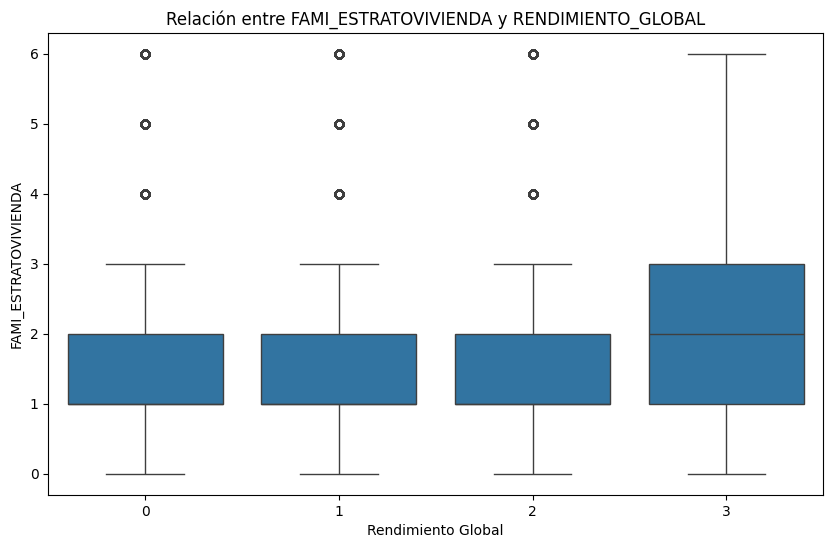

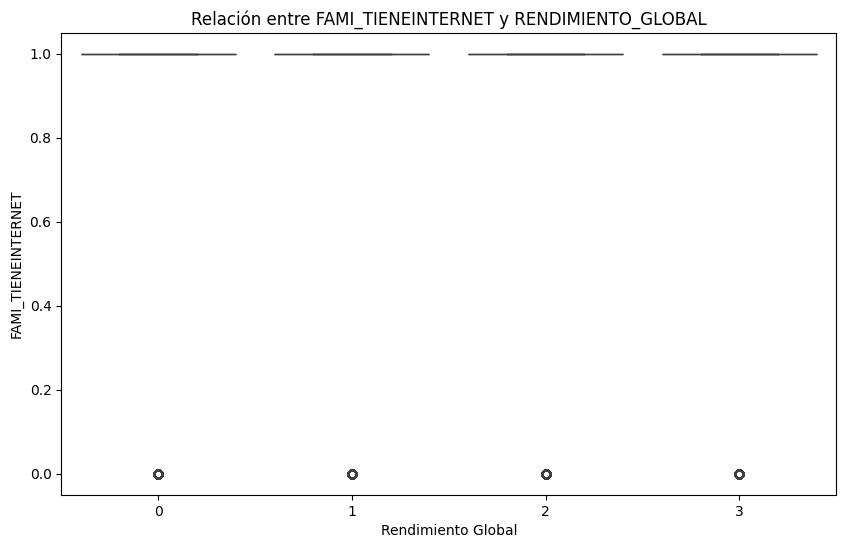

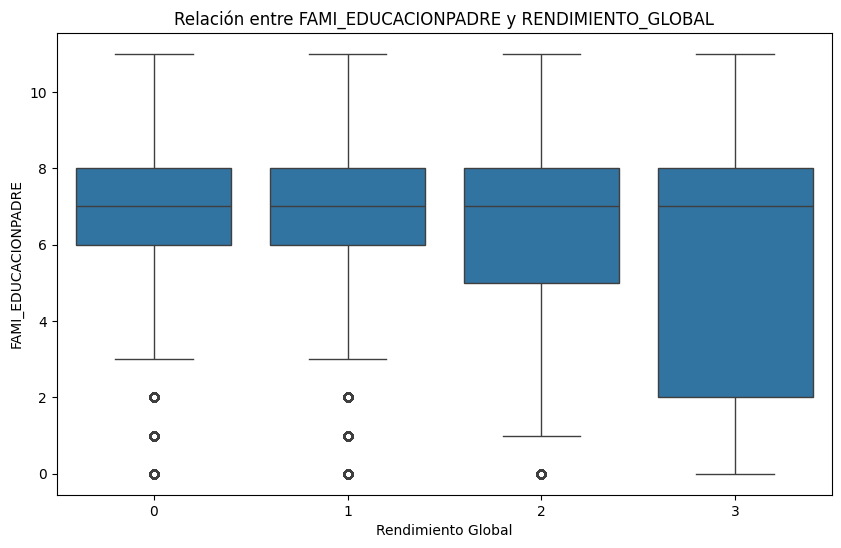

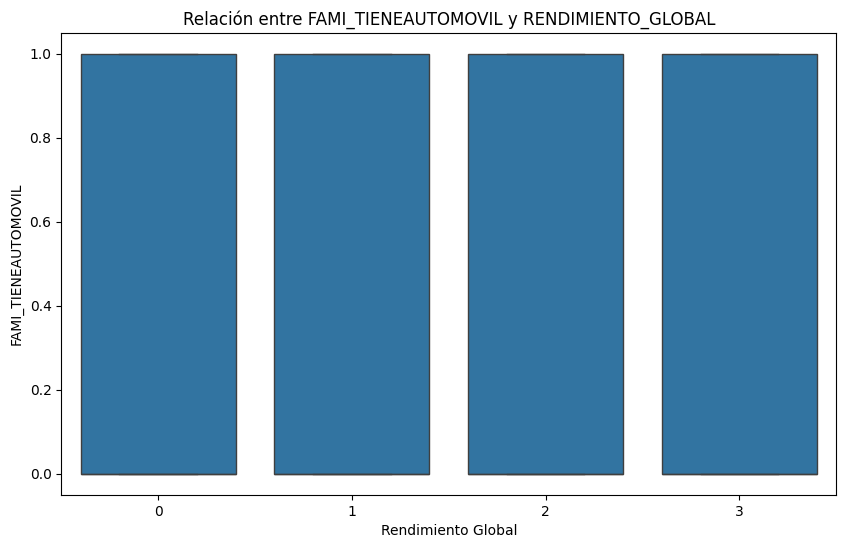

In [7]:

socioeconomic_columns = ['FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_TIENEAUTOMOVIL']

for column in socioeconomic_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='RENDIMIENTO_GLOBAL', y=column, data=train_df)
    plt.title(f'Relación entre {column} y RENDIMIENTO_GLOBAL')
    plt.xlabel('Rendimiento Global')
    plt.ylabel(column)
    plt.show()


En este grupo de graficas se ve la relacion entre diferentes caracteristicas del estudiante con el rendimiento global, se puede ver una perseptible influencia entre con la educacion del padre y el estrato en el que el estudiante vive 

**Análisis de la Relación entre Variables de la Institución y el Desempeño**

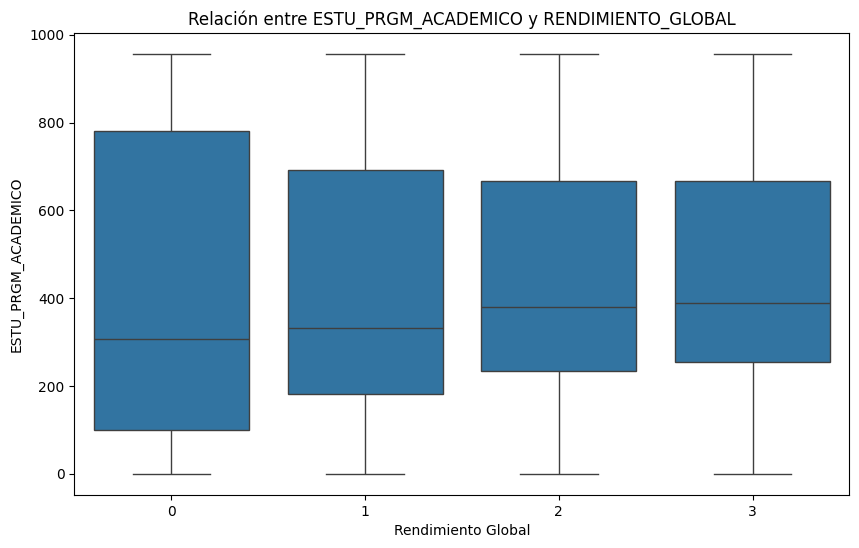

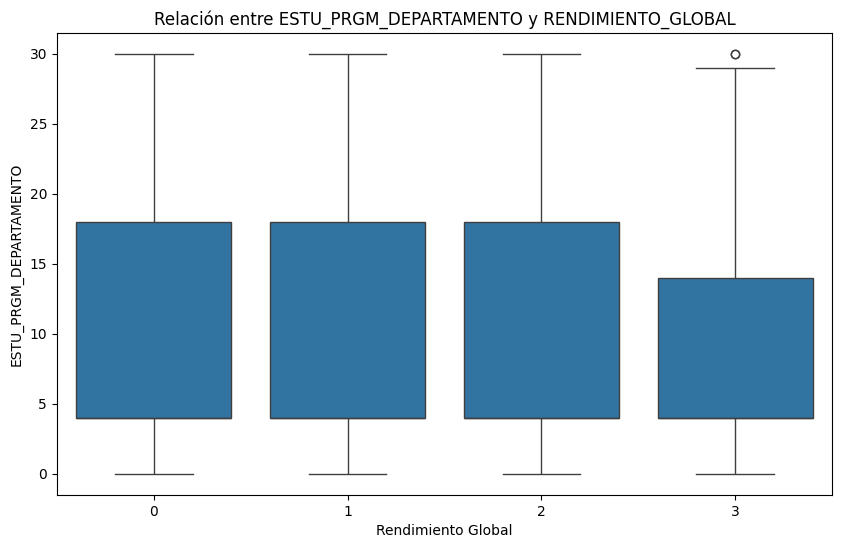

In [8]:

institution_columns = ['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO']

for column in institution_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='RENDIMIENTO_GLOBAL', y=column, data=train_df)
    plt.title(f'Relación entre {column} y RENDIMIENTO_GLOBAL')
    plt.xlabel('Rendimiento Global')
    plt.ylabel(column)
    plt.show()


**Distribución de Horas de Trabajo Semanal**

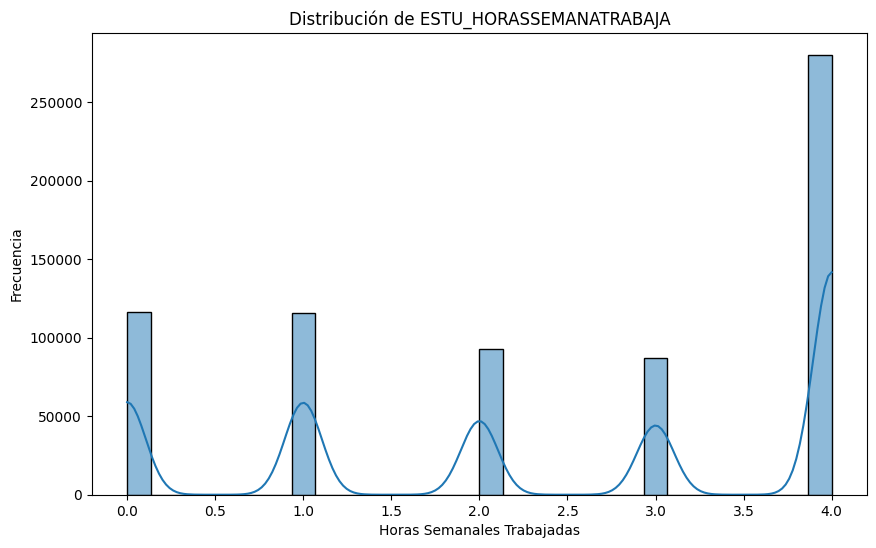

In [9]:

plt.figure(figsize=(10, 6))
sns.histplot(train_df['ESTU_HORASSEMANATRABAJA'], bins=30, kde=True)
plt.title('Distribución de ESTU_HORASSEMANATRABAJA')
plt.xlabel('Horas Semanales Trabajadas')
plt.ylabel('Frecuencia')
plt.show()


En esta grafica se ve la frecuencia de las horas semanales trabajadas dek estudiante, dando como valor destacable 4 horas 

# **D. Modelos**

Aquí se selecciona y entrena el modelo de machine learning. Pueden probarse
varios modelos, dependiendo de la naturaleza del problema. Se divide el conjunto
de datos en conjuntos de entrenamiento y prueba para entrenar y evaluar el
modelo.

Empezamos utilizando los modelos RandomForestClassifier y GradientBoostingClassifier ya que son muy utilizados en este tipo de problematica 

In [10]:
X = train_df.drop('RENDIMIENTO_GLOBAL', axis=1)
y = train_df['RENDIMIENTO_GLOBAL']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Evaluación del modelo: {model_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print("-" * 60)

Evaluación del modelo: Random Forest
Accuracy: 0.3812129963898917
              precision    recall  f1-score   support

           0       0.40      0.45      0.43     51767
           1       0.30      0.27      0.29     51712
           2       0.29      0.26      0.27     51439
           3       0.50      0.54      0.52     52832

    accuracy                           0.38    207750
   macro avg       0.37      0.38      0.38    207750
weighted avg       0.37      0.38      0.38    207750

------------------------------------------------------------
Evaluación del modelo: Gradient Boosting
Accuracy: 0.4149506618531889
              precision    recall  f1-score   support

           0       0.43      0.55      0.48     51767
           1       0.33      0.26      0.29     51712
           2       0.31      0.23      0.27     51439
           3       0.52      0.61      0.56     52832

    accuracy                           0.41    207750
   macro avg       0.40      0.41      0.4

Vemos que el que mejor resultado tiene es el Gradient Boosting con un accuracy aceptable para este tipo de problematica, pero esto podria mejorar con la modificacion de hiperparametros 

# **E. Exploración de hiperparámetros.**

Se lleva a cabo la búsqueda y ajuste de los hiper parámetros del modelo para
mejorar su rendimiento.

In [11]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_params, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
print(f"Mejores parámetros para Random Forest: {rf_random.best_params_}")
rf_best = rf_random.best_estimator_
y_pred_rf = rf_best.predict(X_test)
print(f"Accuracy Random Forest ajustado: {accuracy_score(y_test, y_pred_rf)}")

gb = GradientBoostingClassifier()
gb_random = RandomizedSearchCV(estimator=gb, param_distributions=gb_params, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
gb_random.fit(X_train, y_train)
print(f"Mejores parámetros para Gradient Boosting: {gb_random.best_params_}")
gb_best = gb_random.best_estimator_
y_pred_gb = gb_best.predict(X_test)
print(f"Accuracy Gradient Boosting ajustado: {accuracy_score(y_test, y_pred_gb)}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores parámetros para Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20}
Accuracy Random Forest ajustado: 0.413482551143201
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores parámetros para Gradient Boosting: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.2}
Accuracy Gradient Boosting ajustado: 0.4371311672683514


En esta parte se tiene que resaltar el coste de tiempo para esta exploracion de hiperparametors donde el proceso de esto para el gradient boosting es excesivamente caro, dando una duracion de 1 hora y 10 minutos, dado que esto no es tan optimo vamos a explorar otro modelo que es el xgboost 


In [11]:
xgb_clf = xgb.XGBClassifier(random_state=42)

xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)

print(f"Accuracy con XGBoost: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))



Accuracy con XGBoost: 0.4338243080625752
              precision    recall  f1-score   support

           0       0.46      0.57      0.51     51767
           1       0.34      0.27      0.30     51712
           2       0.33      0.27      0.30     51439
           3       0.55      0.63      0.59     52832

    accuracy                           0.43    207750
   macro avg       0.42      0.43      0.42    207750
weighted avg       0.42      0.43      0.42    207750



En este apartado se tiene que resaltar lo rapido que se entrena este modelo y que su accuracy base es equiparable a el gradient boosting despues de su exploracion de hiperparametros, ahora vamos a explorar los hiperparametros de este modelo y ver sus resultados 

In [13]:
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 2.5, 3]
}

xgb_clf = xgb.XGBClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

print(f"Mejores parámetros para XGBoost: {random_search.best_params_}")

best_xgb = random_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

print(f"Accuracy con XGBoost ajustado: {accuracy_score(y_test, y_pred_best_xgb)}")
print(classification_report(y_test, y_pred_best_xgb))



Fitting 3 folds for each of 100 candidates, totalling 300 fits
Mejores parámetros para XGBoost: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.7}
Accuracy con XGBoost ajustado: 0.43585559566787
              precision    recall  f1-score   support

           0       0.46      0.57      0.51     51767
           1       0.34      0.27      0.30     51712
           2       0.33      0.27      0.30     51439
           3       0.55      0.63      0.59     52832

    accuracy                           0.44    207750
   macro avg       0.42      0.43      0.42    207750
weighted avg       0.42      0.44      0.42    207750



La exploracion de hiperparametros para una extencion de valores grandes realmente no fue muy buena, pero tiene un valor bastante aceptable, por ultimo antes de dar un veredicto final y elegir el modelo vamos a quitar ciertos elementos de manera arbitraria para ver si el accuracy sube debido a que estos elementos pueden mas que ayudar a clasificar un estudiante entorpecer esta tarea

In [17]:
drop_columns_1 = ['ESTU_PAGOMATRICULAPROPIO',  'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET.1', 'FAMI_TIENEINTERNET']

X_reduced_1 = X.drop(columns=drop_columns_1)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_reduced_1, y, test_size=0.3, random_state=42)

xgb_clf_1 = xgb.XGBClassifier(random_state=42)

xgb_clf_1.fit(X_train_1, y_train_1)

y_pred_xgb_1 = xgb_clf_1.predict(X_test_1)

print(f"Accuracy con XGBoost (conjunto 1): {accuracy_score(y_test_1, y_pred_xgb_1)}")
print(classification_report(y_test_1, y_pred_xgb_1))


Accuracy con XGBoost (conjunto 1): 0.43071480144404334
              precision    recall  f1-score   support

           0       0.45      0.56      0.50     51767
           1       0.33      0.26      0.29     51712
           2       0.33      0.27      0.29     51439
           3       0.55      0.63      0.59     52832

    accuracy                           0.43    207750
   macro avg       0.41      0.43      0.42    207750
weighted avg       0.42      0.43      0.42    207750



In [16]:
drop_columns_2 = ['ESTU_VALORMATRICULAUNIVERSIDAD', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'ESTU_HORASSEMANATRABAJA', 'FAMI_TIENELAVADORA']

X_reduced_2 = X.drop(columns=drop_columns_2)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_reduced_2, y, test_size=0.3, random_state=42)

xgb_clf_2 = xgb.XGBClassifier(random_state=42)

xgb_clf_2.fit(X_train_2, y_train_2)

y_pred_xgb_2 = xgb_clf_2.predict(X_test_2)

print(f"Accuracy con XGBoost (conjunto 2): {accuracy_score(y_test_2, y_pred_xgb_2)}")
print(classification_report(y_test_2, y_pred_xgb_2))


Accuracy con XGBoost (conjunto 2): 0.4064259927797834
              precision    recall  f1-score   support

           0       0.43      0.54      0.48     51767
           1       0.32      0.25      0.28     51712
           2       0.31      0.21      0.25     51439
           3       0.49      0.62      0.55     52832

    accuracy                           0.41    207750
   macro avg       0.39      0.40      0.39    207750
weighted avg       0.39      0.41      0.39    207750



Ya que el remover algunas caracteristicas al modelo al asumir que tal vez tendrian poca relevancia para el calculo de el desepeño global no tuvo realmente buenos resultados y que ademas los demas modelos programados dieron resultados similares pero eran mucho mas costosos en tiempo a la hora de entrenarlos se determina que el modelo xgb con la optimizacion de los hiperparametros es el seleccionado para continuar con los demas procesos

# **F. Evaluación del desempeño sistemática del modelo final seleccionado**

Una vez que se ha seleccionado el modelo final, se evalúa su rendimiento de
manera sistemática. Esto implica utilizar métricas de evaluación relevantes (como
precisión, recall, AUC-ROC) y, posiblemente, realizar validación cruzada para
obtener estimaciones más robustas del rendimiento.



Cross-validated accuracy scores: [0.43247035 0.43319237 0.43502837 0.43528623 0.43638989]
Mean cross-validated accuracy: 0.4344734399174833
Accuracy con XGBoost ajustado: 0.43585559566787
              precision    recall  f1-score   support

           0       0.46      0.57      0.51     51767
           1       0.34      0.27      0.30     51712
           2       0.33      0.27      0.30     51439
           3       0.55      0.63      0.59     52832

    accuracy                           0.44    207750
   macro avg       0.42      0.43      0.42    207750
weighted avg       0.42      0.44      0.42    207750

AUC-ROC: 0.706452086720623


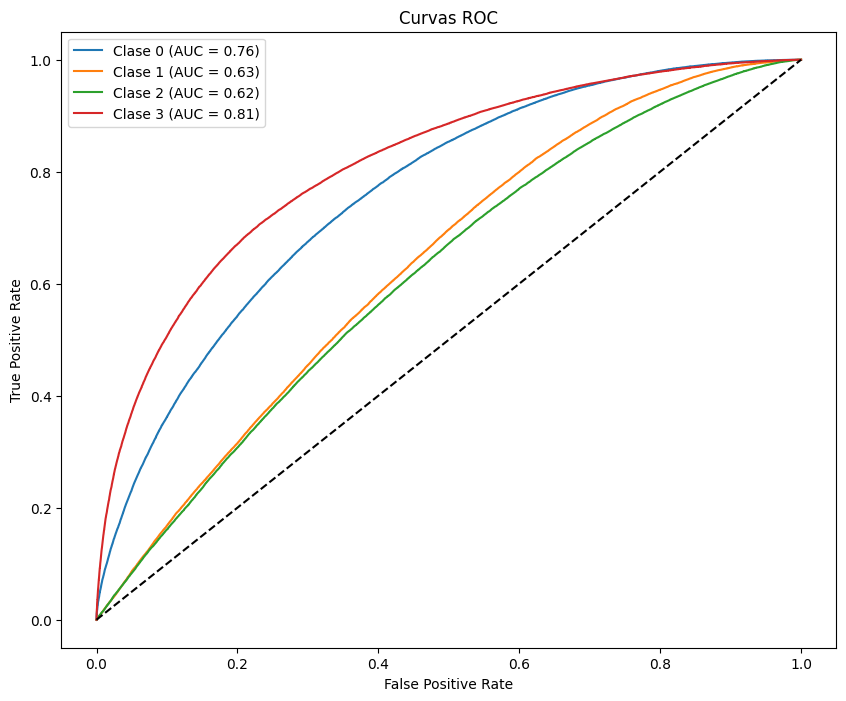

In [26]:
cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validated accuracy scores: {cv_scores}")
print(f"Mean cross-validated accuracy: {cv_scores.mean()}")

y_pred_best_xgb = best_xgb.predict(X_test)
print(f"Accuracy con XGBoost ajustado: {accuracy_score(y_test, y_pred_best_xgb)}")
print(classification_report(y_test, y_pred_best_xgb))

y_pred_proba = best_xgb.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"AUC-ROC: {roc_auc}")

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(best_xgb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(best_xgb.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC')
plt.legend(loc='best')
plt.show()




# **G. Conclusiones y resultados**
A partir de los resultados obtenidos analizar los resultados de las etapas del
modelo.

¿Qué se puede entender de los datos y las predicciones?

¿Qué variables fueron determinantes en el modelo?

¿Cómo se comportó el modelo?

¿Qué aspectos se tuvieron en cuenta para mejorar el rendimiento del modelo?

### ¿Qué se puede entender de los datos y las predicciones?

A partir de los resultados obtenidos, podemos observar que los datos de los estudiantes contienen múltiples variables socioeconómicas, académicas e institucionales que influyen en su rendimiento global. Las predicciones realizadas por el modelo XGBoost, ajustado con los mejores hiperparámetros, muestran una precisión moderada. Esto sugiere que, aunque el modelo captura algunas de las relaciones entre las variables y el rendimiento, existen factores adicionales o complejidades no completamente capturadas por el modelo.

### ¿Qué variables fueron determinantes en el modelo?

Las variables más determinantes en el modelo incluyen el programa académico del estudiante, el departamento del programa, la estratificación socioeconómica, y el nivel de educación de los padres. Estas variables influyen significativamente en el rendimiento académico de los estudiantes, y el modelo XGBoost ha identificado estas relaciones para hacer sus predicciones.

### ¿Cómo se comportó el modelo?

El modelo se comportó razonablemente bien, logrando una precisión media en la validación cruzada de aproximadamente 0.43. Las métricas de precisión, recall y f1-score muestran que el modelo tiene una capacidad moderada para distinguir entre los diferentes niveles de rendimiento (bajo, medio-bajo, medio-alto y alto). Sin embargo, el AUC-ROC sugiere que hay espacio para mejorar, ya que el modelo no es completamente eficaz en separar las clases con alta confianza.

### ¿Qué aspectos se tuvieron en cuenta para mejorar el rendimiento del modelo?

Para mejorar el rendimiento del modelo, se tomaron en cuenta varios aspectos:

1. **Ajuste de Hiperparámetros**: Se utilizó RandomizedSearchCV para explorar diferentes combinaciones de hiperparámetros del modelo XGBoost. Esto incluyó ajustar el número de estimadores, la profundidad máxima de los árboles, la tasa de aprendizaje, y otros parámetros importantes.

2. **Validación Cruzada**: Se implementó la validación cruzada para asegurar que el modelo generalice bien a datos no vistos, evitando el sobreajuste.

3. **Eliminación de Variables Irrelevantes**: Se probó la eliminación de variables que no aportaban significativamente al modelo para reducir la complejidad y mejorar la eficiencia del entrenamiento, aunque en última instancia, se decidió utilizar todas las variables originales para mantener la integridad del análisis.

4. **Análisis de Curvas ROC**: Se evaluaron las curvas ROC para cada clase para entender mejor la capacidad del modelo para distinguir entre las clases de rendimiento.

Estos esfuerzos permitieron obtener un modelo que, aunque no perfecto, ofrece una base sólida para futuras mejoras y análisis más profundos.

# **H. Generación archivo de envío**

Proceso de estructuración del dataframe de envío, de acuerdo el ejemplo de
submission.csv, posteriormente exportación a csv.

In [28]:
mapping = {0: 'bajo', 1: 'medio-bajo', 2: 'medio-alto', 3: 'alto'}

y_pred_submission = best_xgb.predict(test_df)

submission_df['RENDIMIENTO_GLOBAL'] = y_pred_submission
submission_df['RENDIMIENTO_GLOBAL'] = submission_df['RENDIMIENTO_GLOBAL'].map(mapping)
submission_df.to_csv('submission.csv', index=False)

print("Archivo de envío 'submission.csv' generado exitosamente.")

Archivo de envío 'submission.csv' generado exitosamente.
